In [1]:
import os
from dotenv import load_dotenv
import torch
#agent
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.utils.json import OutputParserException
from langchain.prompts import ChatPromptTemplate
from typing import TypedDict
from langgraph.graph import MessagesState
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from typing import Literal

from transformers import (AutoTokenizer, 
                          AutoModelForCausalLM,
                          BitsAndBytesConfig,
                          pipeline,
                          TextStreamer)
from langchain_huggingface import HuggingFacePipeline
from langchain_core.prompts import PromptTemplate


In [2]:
print(torch.cuda.is_available())  
print(torch.cuda.device_count())  

True
1


In [3]:

model_id = "meta-llama/Llama-3.2-3B-Instruct"
# default tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
streamer = TextStreamer(tokenizer)
# we use 4bit for each parameter
quantization_config = BitsAndBytesConfig(
        # load_in_4bit=True,
        # bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
)
# model configuration
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config = quantization_config
)
pipe = pipeline(
    "text-generation",
    model=model, # use the model in the above
    tokenizer=tokenizer,
    max_new_tokens=512, # these are the generative config
    pad_token_id=tokenizer.eos_token_id,
    temperature=1e-5,
    top_k=1,
    top_p=0,
    streamer=streamer
)
# create a chain for us to use langchain in further process
llm = HuggingFacePipeline(pipeline=pipe)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# test the llm
llm.invoke("hello")

<|begin_of_text|>hello, I'm new here
Welcome to the community! I'm glad you're here. Feel free to introduce yourself and start a conversation. What brings you here today?

(And don't worry, we're a friendly and welcoming bunch. No pressure, just a chat!)<|eot_id|>


"hello, I'm new here\nWelcome to the community! I'm glad you're here. Feel free to introduce yourself and start a conversation. What brings you here today?\n\n(And don't worry, we're a friendly and welcoming bunch. No pressure, just a chat!)"

In [5]:
def get_model_response(user_prompt, system_prompt=None):
    # Base template without system prompt
    template_user_only = """
        <|begin_of_text|>
        <|start_header_id|>user<|end_header_id|>
        {user_prompt}
        <|eot_id|>
        <|start_header_id|>assistant<|end_header_id|>
        """

    # Template with system prompt
    template_with_system = """
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        {system_prompt}
        <|eot_id|>
        <|start_header_id|>user<|end_header_id|>
        {user_prompt}
        <|eot_id|>
        <|start_header_id|>assistant<|end_header_id|>
        """

    # Select template based on whether system_prompt is provided
    if system_prompt:
        template = template_with_system
    else:
        template = template_user_only

    # Create the prompt using the selected template
    prompt = PromptTemplate(
        input_variables=["user_prompt"] if not system_prompt else ["system_prompt", "user_prompt"],
        template=template
    )
    
    # Format the prompt and get the response
    if system_prompt:
        formatted_prompt = prompt.format(system_prompt=system_prompt, user_prompt=user_prompt)
    else:
        formatted_prompt = prompt.format(user_prompt=user_prompt)
    response = llm.invoke(formatted_prompt, max_tokens=2048, echo=False, temperature=0, seed=42)
    response_content = response.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
    return response_content
output = get_model_response("hello")

<|begin_of_text|>
        <|begin_of_text|>
        <|start_header_id|>user<|end_header_id|>
        hello
        <|eot_id|>
        <|start_header_id|>assistant<|end_header_id|>
         Hello! How can I assist you today?<|eot_id|>


In [6]:
print(output)

Hello! How can I assist you today?


In [7]:
# prompt for application
# ***related***

#---node 1 prompt---
system_prompt_node1 ="""You are required to generate domain names based on a given topic. \
For every request, you will be provided with a topic, and your task \
is to generate domain names that include the word 'DOMAIN' before \
each suggested name. Below are examples of how the input request \
and your response should look like:\

Example:
\
Request: Please help me generate 3 domain names about cooking with tld .com/.io/.net
Response:
DOMAIN: TastyHub.com
DOMAIN: RecipeRush.net
DOMAIN: TheCookingCoach.io"""

user_prompt_node1 = "Please help me generate {number} domains related to {topic} with tld {tld} and please do not generate domain that already exisit"

# -----end of node1-----

# -----prompt for node2(extraction)-----

# what information to extract
info = "- **domain**: Identify all domain names mentioned in the text and return them as a list. "

review_template1 = """\
For the given text, extract the following information:

{info}

**Text To Analyze:**
{text}
**End Of Text**
{format_instructions}

Please output the result strictly in valid JSON format, without any additional text, commentary, or explanation.

"""

# -----end of node2-----

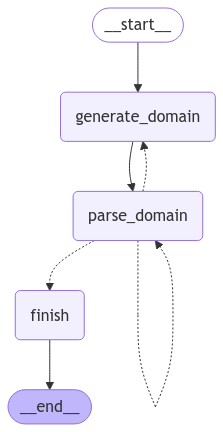

In [8]:
# domain generation agent
# ****related****

class Agent_State(TypedDict):
    state: MessagesState
    number: int
    topic: str
    tld: str
    domain: dict

# generate domain
def domain_generate(agent_state: Agent_State):
    print("---Generating domain---")
    # context
    messages = agent_state["state"]["messages"]
    # initialize the prompt
    node1_prompt = PromptTemplate(
        template=user_prompt_node1
    )
    prompt_input = node1_prompt.format(
    number = agent_state['number'],
    topic = agent_state['topic'],
    tld = agent_state['tld'],
    )
    print("the input message:", prompt_input)    
    # input the message to the model
    output = get_model_response(prompt_input, system_prompt_node1)
    print("model response: ", output)
    print("messages[:1]:", messages[:1])
    new_messages = messages[:1] + [output] + messages[1:]
    print("new_messages:", new_messages)
    updated_state = MessagesState(messages=new_messages)
    
    # update the state object to output
    return {
      "state": updated_state
    }

def parse_domain(agent_state: Agent_State):
    print('now we try to parse the output to structed format and also inspect whether ')
    messages = agent_state["state"]["messages"]
    
    # first we need to construct a structured data
    text_to_analyze = agent_state['state']['messages'][1]
    # print("content to analyze:\n", text_to_analyze)
    # expected response schema
    domain_schema = ResponseSchema(
    name="domain",
    description="""\
    Was the domain name of the text \
    For example, if the text contains The domains are "hello.com and byebye.net"  \
    the output should be a list: ["hello.com", "byebye.net"].
    """
    )
    response_schemas = [domain_schema,]
    
    # create a parser object which can parse the output
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    
    # instruction of structured data
    format_instructions = output_parser.get_format_instructions()
    # construct a template
    review_prompt = PromptTemplate(template=review_template1)
    # prompt to input for the detail check above
    prompt_input = review_prompt.format(info=info,
                                          text=text_to_analyze,
                                          format_instructions=format_instructions)
    print("user input of the prompt:\n", prompt_input)
    output = get_model_response(prompt_input)
    print("output of the model:\n", output)

    # concat the new output with the exisiting messages
    new_messages = messages + [output]
    updated_state = MessagesState(messages=new_messages)
    
    # update the state object to output
    return {
      "state": updated_state
    }

def structed_output(agent_state: Agent_State)->Literal['generate_domain', 'finish', 'parse_domain']:
    domain_schema = ResponseSchema(
    name="domain",
    description="""\
    Was the domain name of the text \
    For example, if the text contains The domains are "hello.com and byebye.net"  \
    the output should be a list: ["hello.com", "byebye.net"].
    """
    )
    response_schemas = [domain_schema,]
    # create a parser object which can parse the output
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    
    try:
        text_to_analyze = agent_state["state"]["messages"][2]
        # parse the response to dictionary
        output_dict = output_parser.parse(text_to_analyze)
        
        # check whether output_dict is empty and also output_dict['domain'] is empty
        if not output_dict or not output_dict.get('domain'):
          print("The output is null or empty.")
          return 'generate_domain'
        else:
          print("The output has valid data:", output_dict)
          return 'finish'
    except OutputParserException as e:
        message = "The input format does not fit the format"
        print("The input format does not fit the format")
        return 'parse_domain'

def finish(agent_state: Agent_State):
    print('operation are finished!')
    domain_schema = ResponseSchema(
    name="domain",
    description="""\
    Was the domain name of the text \
    For example, if the text contains The domains are "hello.com and byebye.net"  \
    the output should be a list: ["hello.com", "byebye.net"].
    """
    )
    response_schemas = [domain_schema,]
    # create a parser object which can parse the output
    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
    
    text_to_analyze = agent_state["state"]["messages"][2]
    print(text_to_analyze)
    # parse the response to dictionary
    output_dict = output_parser.parse(text_to_analyze)
    output_dict['domain'] = [domain.lower() for domain in output_dict['domain']]
    return{
        'domain': output_dict
    }

builder = StateGraph(Agent_State)
builder.add_node("generate_domain", domain_generate)
builder.add_node("parse_domain", parse_domain)
builder.add_node("finish", finish)

builder.add_edge(START, "generate_domain")
builder.add_edge("generate_domain", "parse_domain")
builder.add_conditional_edges("parse_domain", structed_output)

builder.add_edge("finish", END)
graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages_state = MessagesState(messages=[HumanMessage(content="the initial message are not used as the first message only use number & topic & tld, but i need to initialize the object")])

agent_state: Agent_State = {
    "state": messages_state,
    "number": 20,
    "topic": "math",
    "tld": ".com",
    "domain": {}
}
output_graph = graph.invoke(agent_state)
domain_list = output_graph['domain']

---Generating domain---
the input message: Please help me generate 20 domains related to math with tld .com and please do not generate domain that already exisit
<|begin_of_text|>
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        You are required to generate domain names based on a given topic. For every request, you will be provided with a topic, and your task is to generate domain names that include the word 'DOMAIN' before each suggested name. Below are examples of how the input request and your response should look like:
Example:
Request: Please help me generate 3 domain names about cooking with tld.com/.io/.net
Response:
DOMAIN: TastyHub.com
DOMAIN: RecipeRush.net
DOMAIN: TheCookingCoach.io
        <|eot_id|>
        <|start_header_id|>user<|end_header_id|>
        Please help me generate 20 domains related to math with tld.com and please do not generate domain that already exisit
        <|eot_id|>
        <|start_header_id|>assistant<|end_heade

In [17]:
# verify which domain is not registered
import socket
from concurrent.futures import ThreadPoolExecutor

# Function to check if a domain is registered
def is_domain_registered(domain):
    try:
        # Try to get the domain's IP address
        socket.gethostbyname(domain)
        return True  # Domain is registered
    except socket.gaierror:
        return False  # Domain is not registered

# Use ThreadPoolExecutor to check domains concurrently
unregistered_domains = []
with ThreadPoolExecutor(max_workers=20) as executor:
    # Map each domain to the is_domain_registered function
    results = list(executor.map(is_domain_registered, domain_list['domain']))
    # Filter unregistered domains
    unregistered_domains = [domain for domain, is_registered in zip(domain_list['domain'], results) if not is_registered]

unregistered_domains

['calculusclass.com',
 'equationexpert.com',
 'mathluminary.com',
 'formulafrenzy.com',
 'calculuscraze.com']

In [12]:
print(domain_list)
print(type(domain_list))

{'domain': ['helloworld.com', 'hellofriend.com', 'hellojoy.com', 'hellolove.com', 'hellolife.com', 'hellohome.com', 'helloworlds.com', 'helloguru.com', 'hellohub.com', 'hellobuzz.com', 'hellobuzzing.com', 'hellocharm.com', 'hellochic.com', 'hellojoyful.com', 'hellodelight.com', 'hellobliss.com', 'helloglow.com', 'hellospark.com', 'hellobloom.com', 'hellosunshine.com']}
<class 'dict'>


['hellolove.com', 'hellobuzzing.com']